In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
from pymodulon.compare import *
from pymodulon.io import *

In [3]:
ica_data_dir = '../data/interim/ica_runs/220'

## Load the sample table (i.e. metadata file)

In [4]:
df_metadata = pd.read_csv('../data/interim/metadata_qc.csv',index_col=0)
df_metadata[['project_name','condition_name','rep_name','reference_condition','DOI']].head()

,project_name,condition_name,rep_name,reference_condition,DOI
CJ522_f_1,Muconate,CJ522_fructose,1.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_f_2,Muconate,CJ522_fructose,2.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_f_3,Muconate,CJ522_fructose,3.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_fg_1,Muconate,CJ522_fructose_glucose,1.0,KT2440_glucose,10.1016/j.ymben.2020.01.001
CJ522_fg_2,Muconate,CJ522_fructose_glucose,2.0,KT2440_glucose,10.1016/j.ymben.2020.01.001


In [5]:
df_metadata=df_metadata.rename(columns={'project_name':'project',
    'condition_name':'condition'})

In [6]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Load the TRN file

In [7]:
df_trn = pd.read_csv('../data/external/TRN_update_210616.csv')
df_trn.head()

,regulator,regulator_id,gene_id,gene_name,Pputida,evidence
0,Zur,PP_0119,PP_0117,znuB,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
1,Zur,PP_0119,PP_0118,znuC,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
2,Zur,PP_0119,PP_0119,zur,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
3,Zur,PP_0119,PP_0120,znuA,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."
4,Zur,PP_0119,PP_0506,PP_0506,True,"RegPrecise, http://regprecise.sbpdiscovery.org..."


The `regulator` and `gene_id` must be filled in for each row

In [8]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data

In [9]:
ica_data_dir

'../data/interim/ica_runs/220'

In [10]:
#ensure every columns are sorted

A=pd.read_csv(path.join(ica_data_dir,'A.csv'),index_col=0)
X=pd.read_csv('../data/processed_data/log_tpm_norm.csv',index_col=0)
set(X.columns)-set(A.columns)
A[X.columns].to_csv(path.join(ica_data_dir,'A.csv'))

In [11]:
X_log_tpm=pd.read_csv('../data/interim/log_tpm_qc.csv',index_col=0)
set(X.columns)-set(X_log_tpm.columns)
X_log_tpm[X.columns].to_csv('../data/interim/log_tpm_qc.csv')

In [12]:
#M matrix renamed as S matrix

ica_data = IcaData(M = path.join(ica_data_dir,'S.csv'),
                   A = path.join(ica_data_dir,'A.csv'),
                   X = '../data/processed_data/log_tpm_norm.csv',
                   log_tpm = '../data/interim/log_tpm_qc.csv',
                   gene_table = '../data/processed_data/gene_info.csv',
                   sample_table = '../data/raw_data/sample_table.csv',
                   trn = df_trn)

In [13]:
#update gene names

ica_data.gene_table.loc['PP_2665', 'gene_name'] = 'pedR1'
ica_data.gene_table.loc['PP_4283', 'gene_name'] = 'gclR'
ica_data.gene_table.loc['PP_0119', 'gene_name'] = 'zur'
ica_data.gene_table.loc['PP_4734', 'gene_name'] = 'lldR'
ica_data.gene_table.loc['PP_5292', 'gene_name'] = 'crc'
ica_data.gene_table.loc['PP_3738', 'gene_name'] = 'vanR'
ica_data.gene_table.loc['PP_3740', 'gene_name'] = 'vanK'
ica_data.gene_table.loc['PP_3415', 'gene_name'] = 'gnuR'
ica_data.gene_table.loc['PP_4039', 'gene_name'] = 'pydR'
ica_data.gene_table.loc['PP_4371', 'gene_name'] = 'fleR'
ica_data.gene_table.loc['PP_0740', 'gene_name'] = 'pplR1'
ica_data.gene_table.loc['PP_1366', 'gene_name'] = 'turA'
ica_data.gene_table.loc['PP_3765', 'gene_name'] = 'turB'
ica_data.gene_table.loc['PP_4470', 'gene_name'] = 'amrZ'
ica_data.gene_table.loc['PP_1637', 'gene_name'] = 'finR'
ica_data.gene_table.loc['PP_2144', 'gene_name'] = 'psrA'
ica_data.gene_table.loc['PP_0792', 'gene_name'] = 'fruR'
ica_data.gene_table.loc['PP_0997', 'gene_name'] = 'gcsR'
ica_data.gene_table.loc['PP_3539', 'gene_name'] = 'liuR'
ica_data.gene_table.loc['PP_5140', 'gene_name'] = 'cadR'
ica_data.gene_table.loc['PP_0594', 'gene_name'] = 'rutR-I'

ica_data.gene_table.loc['PP_3088', 'gene_name'] = 'tssA1'
ica_data.gene_table.loc['PP_3089', 'gene_name'] = 'hcp1'
ica_data.gene_table.loc['PP_3090', 'gene_name'] = 'tagP1'
ica_data.gene_table.loc['PP_5561', 'gene_name'] = 'tagF1'
ica_data.gene_table.loc['PP_3091', 'gene_name'] = 'tssM1'
ica_data.gene_table.loc['PP_3092', 'gene_name'] = 'tssL1'
ica_data.gene_table.loc['PP_3093', 'gene_name'] = 'tssK1'
ica_data.gene_table.loc['PP_3094', 'gene_name'] = 'tssJ1'
ica_data.gene_table.loc['PP_3096', 'gene_name'] = 'tssG1'
ica_data.gene_table.loc['PP_3097', 'gene_name'] = 'tssF1'
ica_data.gene_table.loc['PP_3098', 'gene_name'] = 'tssE1'
ica_data.gene_table.loc['PP_3100', 'gene_name'] = 'tssB1'
ica_data.gene_table.loc['PP_5562', 'gene_name'] = 'tagX1'


  0%|          | 0/39 [00:00<?, ?it/s]

1350

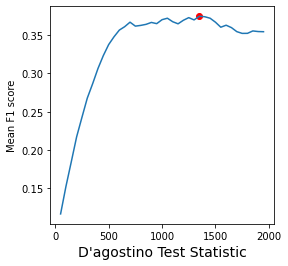

In [14]:
ica_data.reoptimize_thresholds()

In [15]:
from pymodulon.util import explained_variance

In [16]:
ica_data

In [17]:
# calculate the exaplained variance of the gene expression profiles

In [18]:
explained_variance(ica_data)

0.7574863487929132

In [19]:
# add individual explained variance for each iModulon

for k in ica_data.imodulon_table.index:
    ica_data.imodulon_table.loc[k, 'exp_var'] = explained_variance(
        ica_data, imodulons=k)

# Manually changing threshold 

In [20]:
ica_data.change_threshold(39,0.08) # to include genes in the same regulon, original value: 0.08841650883937846
ica_data.change_threshold(66,0.132) # to include genes in the same regulon, original value: 0.08841650883937846

ica_data.change_threshold(68,0.053) # to include genes in the same TUs, original value: 0.0864759105949802
ica_data.change_threshold(72,0.140) # to include genes in the same TUs, original value: 0.14520632726624155
ica_data.change_threshold(73,0.11) # to include genes in the same regulon, original value: 0.13740759854641915
ica_data.change_threshold(74,0.11) # to include adjacent genes, original value: 0.141249602568

# Regulatory iModulons

In [21]:
ica_data.compute_trn_enrichment(save=True,fdr=.0001)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,1,GbdR,1.691643e-31,1.353314e-30,0.472222,0.548387,0.507463,17.0,31.0,36.0,1.0
1,1,RoxR,7.899450e-18,3.159780e-17,0.361111,0.224138,0.276596,13.0,58.0,36.0,1.0
2,4,PedR1,3.624905e-05,7.249811e-05,1.000000,0.058824,0.111111,2.0,34.0,2.0,1.0
3,12,GclR,1.182626e-23,8.278380e-23,0.714286,0.526316,0.606061,10.0,19.0,14.0,1.0
4,12,RutR-I,9.452290e-13,3.308301e-12,0.357143,0.714286,0.476190,5.0,7.0,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
57,71,Fur,6.829839e-23,3.756412e-22,0.416667,0.306122,0.352941,15.0,49.0,36.0,1.0
58,73,GcsR,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,4.0,4.0,4.0,1.0
59,76,LiuR,4.328164e-10,3.895347e-09,0.333333,0.571429,0.421053,4.0,7.0,12.0,1.0
60,78,HmgR,2.325027e-06,2.325027e-06,0.500000,0.500000,0.500000,2.0,4.0,4.0,1.0


In [22]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,exp_var
1,GbdR,1.691643e-31,1.353314e-30,0.472222,0.548387,0.507463,17.0,31.0,36.0,1.0,0.007779
4,PedR1,3.624905e-05,7.249811e-05,1.000000,0.058824,0.111111,2.0,34.0,2.0,1.0,0.001146
12,GclR,1.182626e-23,8.278380e-23,0.714286,0.526316,0.606061,10.0,19.0,14.0,1.0,0.007291
13,FnrA,3.175401e-06,2.222781e-05,0.187500,0.272727,0.222222,3.0,11.0,16.0,1.0,0.007104
19,Zur,9.059640e-41,4.529820e-40,0.515152,1.000000,0.680000,17.0,17.0,33.0,1.0,0.018591
21,LldR,5.575521e-10,1.115104e-09,0.750000,0.750000,0.750000,3.0,4.0,4.0,1.0,0.003317
22,VanR,1.394068e-10,4.182205e-10,0.750000,1.000000,0.857143,3.0,3.0,4.0,1.0,0.002391
24,ColR,9.406767e-07,3.762707e-06,0.272727,0.272727,0.272727,3.0,11.0,11.0,1.0,0.003427
27,BenR,5.264419e-12,2.632210e-11,0.400000,1.000000,0.571429,4.0,4.0,10.0,1.0,0.004793
28,PtxS,7.279373e-24,1.455875e-23,0.727273,1.000000,0.842105,8.0,8.0,11.0,1.0,0.012209


In [23]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[:5])

[0, 'GbdR', 2, 3, 'PedR1-1']


# Functional iModulons

## KEGG Enrichments

In [24]:
DF_KEGG = pd.read_csv('../data/sequence_files/kegg_mapping.csv',index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
2485,PP_0006,KEGG_pathway,map02024
2486,PP_0006,KEGG_pathway,map03060
2487,PP_0006,KEGG_pathway,map03070
2490,PP_0010,KEGG_pathway,map02020
2491,PP_0010,KEGG_pathway,map04112


In [25]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

In [26]:
# Perform enrichment

In [27]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [28]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,GbdR,map00260,2.103570e-07,0.000046,0.166667,0.142857,0.153846,6.0,42.0,36.0
1,GbdR,map00680,2.706639e-05,0.002991,0.111111,0.142857,0.125000,4.0,28.0,36.0
2,GbdR,map01100,8.164246e-04,0.060143,0.333333,0.017544,0.033333,12.0,684.0,36.0
3,7,map00010,2.018263e-05,0.002230,0.300000,0.093750,0.142857,3.0,32.0,10.0
4,7,map00030,1.338087e-05,0.002230,0.300000,0.107143,0.157895,3.0,28.0,10.0


In [29]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,GbdR,M00208,4.910679e-06,0.001404,0.083333,0.500000,0.142857,3.0,6.0,36.0
1,7,M00001,9.122944e-07,0.000261,0.300000,0.250000,0.272727,3.0,12.0,10.0
2,7,M00114,4.344812e-05,0.006213,0.200000,0.333333,0.250000,2.0,6.0,10.0
3,7,M00004,1.900744e-04,0.018120,0.200000,0.166667,0.181818,2.0,12.0,10.0
4,9,M00009,1.414946e-06,0.000405,0.090909,0.238095,0.131579,5.0,21.0,55.0


### Convert KEGG IDs to human-readable names

In [30]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

In [31]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,GbdR,map00260,2.103570e-07,0.000046,0.166667,0.142857,0.153846,6.0,42.0,36.0,"Glycine, serine and threonine metabolism"
1,GbdR,map00680,2.706639e-05,0.002991,0.111111,0.142857,0.125000,4.0,28.0,36.0,Methane metabolism
2,GbdR,map01100,8.164246e-04,0.060143,0.333333,0.017544,0.033333,12.0,684.0,36.0,Metabolic pathways
3,7,map00010,2.018263e-05,0.002230,0.300000,0.093750,0.142857,3.0,32.0,10.0,Glycolysis / Gluconeogenesis
4,7,map00030,1.338087e-05,0.002230,0.300000,0.107143,0.157895,3.0,28.0,10.0,Pentose phosphate pathway


In [32]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,GbdR,M00208,4.910679e-06,0.001404,0.083333,0.500000,0.142857,3.0,6.0,36.0,NaN
1,7,M00001,9.122944e-07,0.000261,0.300000,0.250000,0.272727,3.0,12.0,10.0,"Glycolysis (Embden-Meyerhof pathway), glucose ..."
2,7,M00114,4.344812e-05,0.006213,0.200000,0.333333,0.250000,2.0,6.0,10.0,"Ascorbate biosynthesis, plants, fructose-6P =>..."
3,7,M00004,1.900744e-04,0.018120,0.200000,0.166667,0.181818,2.0,12.0,10.0,Pentose phosphate pathway (Pentose phosphate c...
4,9,M00009,1.414946e-06,0.000405,0.090909,0.238095,0.131579,5.0,21.0,55.0,"Citrate cycle (TCA cycle, Krebs cycle)"


### Save files

In [33]:
DF_pathway_enrich.to_csv('../data/processed_data/kegg_pathway_enrichments.csv')
DF_pathway_enrich.to_csv('../data/processed_data/kegg_module_enrichments.csv')

# Check for single gene iModulons

In [34]:
sg_imods = ica_data.find_single_gene_imodulons()
sg_imods

[6, 29, 50, 63, 66, 75, 82]

In [35]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [36]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

# iModulon renaming after manual curation

In [37]:
#Regulatory iModulon renaming
ica_data.rename_imodulons({'PydR':'PydR/RpoS'})
ica_data.rename_imodulons({'FleQ-2':'FleQ/Fur'})
ica_data.rename_imodulons({'FleQ-1':'FleQ/AmrZ'})
ica_data.rename_imodulons({'PP_0204':'PP_0204/CysB'})

#iModulons do not have significant overlaps with known regulons were manually curated. Please see the manuscript for details.

ica_data.rename_imodulons({0:'Null-1'})
ica_data.rename_imodulons({2:'PP_2034-7'})
ica_data.rename_imodulons({3:'Multiple stress-1'})
ica_data.rename_imodulons({5:'Acetate stress'})
ica_data.rename_imodulons({'single_gene_1':'Noise-1'})
ica_data.rename_imodulons({7:'Genomic-1'})
ica_data.rename_imodulons({8:'Zinc'})
ica_data.rename_imodulons({9:'TCA cycle'})
ica_data.rename_imodulons({10:'Redox'})
ica_data.rename_imodulons({11:'Pentose and glucuronate'})
ica_data.rename_imodulons({14:'Osmotic stress-1'})
ica_data.rename_imodulons({15:'Phage-1'})
ica_data.rename_imodulons({16:'Multiple stress-2'})
ica_data.rename_imodulons({17:'Putrescine'})
ica_data.rename_imodulons({18:'Unchar-1'})
ica_data.rename_imodulons({20:'Unchar-2'})
ica_data.rename_imodulons({23:'Osmotic stress-2'})
ica_data.rename_imodulons({25:'Unchar-3'})
ica_data.rename_imodulons({26:'Exporters'})
ica_data.rename_imodulons({'single_gene_2':'Noise-2'})
ica_data.rename_imodulons({33:'Unchar-4'})
ica_data.rename_imodulons({34:'Null-2'})
ica_data.rename_imodulons({35:'T6SS'})
ica_data.rename_imodulons({36:'InfA'})
ica_data.rename_imodulons({40:'Citrate'})
ica_data.rename_imodulons({41:'Unchar-5'})
ica_data.rename_imodulons({42:'Unchar-6'})
ica_data.rename_imodulons({45:'Genomic-2'})
ica_data.rename_imodulons({47:'Unchar-7'})
ica_data.rename_imodulons({'single_gene_3':'Noise-3'})
ica_data.rename_imodulons({51:'Phage-2'})
ica_data.rename_imodulons({53:'Acetate'})
ica_data.rename_imodulons({55:'Translation'})
ica_data.rename_imodulons({59:'IonicLiquid'})
ica_data.rename_imodulons({61:'Unchar-8'})
ica_data.rename_imodulons({'single_gene_4':'Noise-4'})
ica_data.rename_imodulons({'single_gene_5':'Sulfur'})
ica_data.rename_imodulons({72:'PP_2260-3'})
ica_data.rename_imodulons({74:'PP_0615-8'})
ica_data.rename_imodulons({'single_gene_6':'Noise-5'})
ica_data.rename_imodulons({77:'Unchar-9'})
ica_data.rename_imodulons({79:'Null-3'})
ica_data.rename_imodulons({81:'AA transport'})
ica_data.rename_imodulons({'single_gene_7':'Genomic-3'})
ica_data.rename_imodulons({83:'Noise-6'})

# Adding size & explained variance information to the iModulon table

In [38]:
for i in ica_data.imodulon_table.index:
    ica_data.imodulon_table.loc[i,'imodulon_size']=len(ica_data.view_imodulon(i).index)
    ica_data.imodulon_table.loc[i,'TU_size']=len(ica_data.view_imodulon(i).operon.unique())
    ica_data.imodulon_table.loc[i, 'exp_var'] = explained_variance(ica_data, imodulons=i)

# Adding additional information for regulatory iModulons

In [39]:
for i in ica_data.imodulon_table.index:
    if pd.isna(ica_data.imodulon_table.loc[i, 'regulator']):
        pass
    else:
        if(ica_data.imodulon_table.loc[i,"precision"]>0.6):
            if(ica_data.imodulon_table.loc[i,"recall"]>0.6):
                ica_data.imodulon_table.loc[i,"reg_type"]="Well-matched"
            else:
                ica_data.imodulon_table.loc[i,"reg_type"]="Subset"
        else:
            if(ica_data.imodulon_table.loc[i,"recall"]>0.6):
                ica_data.imodulon_table.loc[i,"reg_type"]="New_containing"
            else:
                ica_data.imodulon_table.loc[i,"reg_type"]="Closet-match"

# Adding information from manual categorization & curation

In [40]:
curation=pd.read_csv('../data/processed_data/category_function.csv',index_col=0)

In [41]:
curation

,Category,Sub_category,Function,iModulon_type
Null-1,Uncharacterized,Empty,Null,Uncharacterized
GbdR,Stress,Osmotic stress,Glycine Betaine Catabolism,Regulatory
PP_2034-7,Carbon,Aromatics catabolism,Benzoate catabolism,Functional
Multiple stress-1,Stress,Multiple stress,Multiple stress response,Functional
PedR1-1,Carbon,Aromatics catabolism,Alcohol/aromatics catabolism,Regulatory
...,...,...,...,...
Null-3,Uncharacterized,Empty,Null,Uncharacterized
GlcC,Carbon,Acid catabolism,Glycolate catabolism,Regulatory
AA transport,Amino acid,Transportation,Amino acid transportation,Functional
Genomic-3,Genomic,Genomic iModulon,TurB deletion,Genomic


In [42]:
for i in curation.index:
    ica_data.imodulon_table.loc[i,'Category']=curation.loc[i,'Category']
    ica_data.imodulon_table.loc[i,'Sub_category']=curation.loc[i,'Sub_category']
    ica_data.imodulon_table.loc[i,'Function']=curation.loc[i,'Function']
    ica_data.imodulon_table.loc[i,'iModulon_type']=curation.loc[i,'iModulon_type']

# Save iModulon object

In [43]:
save_to_json(ica_data,'../putidaPRECISE321.json')

In [44]:
ica_data.imodulon_table.to_csv('../data/processed_data/imodulon_table.csv')